# Dealing with imbalanced data by changing classification cut-off levels

A problem with machine learning models is that they may end up biased towards the majority class, and under-predict the minority class(es).

Some models (including sklearn's logistic regression) allow for thresholds of classification to be changed. This can help rebalance classification in models, especially where there is a binary classification (e.g. survived or not).

Here we create a more imbalanced data set from the Titanic set, by dropping half the survivors.

We vary the probability cut-off for a 'survived' classification, and examine the effect of classification probability cut-off on a range of accuracy measures.

Note: You will need to look at the help files and documentation of other model types to find whether they have options to change classification cut-off levels.

In [1]:
# Hide warnings (to keep notebook tidy; do not usually do this)
import warnings
warnings.filterwarnings("ignore")

## Load modules

A standard Anaconda install of Python (https://www.anaconda.com/distribution/) contains all the necessary modules.

In [2]:
import numpy as np
import pandas as pd
# Import machine learning methods
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold

## Load data

The section below downloads pre-processed data, and saves it to a subfolder (from where this code is run).
If data has already been downloaded that cell may be skipped.

In [3]:
download_required = True

if download_required:
    
    # Download processed data:
    address = 'https://raw.githubusercontent.com/MichaelAllen1966/' + \
                '1804_python_healthcare/master/titanic/data/processed_data.csv'
    
    data = pd.read_csv(address)

    # Create a data subfolder if one does not already exist
    import os
    data_directory ='./data/'
    if not os.path.exists(data_directory):
        os.makedirs(data_directory)

    # Save data
    data.to_csv(data_directory + 'processed_data.csv', index=False)

In [4]:
data = pd.read_csv('data/processed_data.csv')
# Make all data 'float' type
data = data.astype(float)

The first column is a passenger index number. We will remove this, as this is not part of the original Titanic passenger data.

In [5]:
# Drop Passengerid (axis=1 indicates we are removing a column rather than a row)
# We drop passenger ID as it is not original data

data.drop('PassengerId', inplace=True, axis=1)

## Artificially reduce the number of survivors (to make data set more imbalanced)

In [6]:
# Shuffle original data
data = data.sample(frac=1.0) # Sampling with a fraction of 1.0 shuffles data

# Create masks for filters
mask_died = data['Survived'] == 0
mask_survived = data['Survived'] == 1

# Filter data
died = data[mask_died]
survived = data[mask_survived]

# Reduce survived by half
survived = survived.sample(frac=0.5)

# Recombine data and shuffle
data = pd.concat([died, survived])
data = data.sample(frac=1.0) 

# Show average of survived
survival_rate = data['Survived'].mean()
print ('Proportion survived:', np.round(survival_rate,3))

Proportion survived: 0.238


## Define function to standardise data

In [7]:
def standardise_data(X_train, X_test):
    
    # Initialise a new scaling object for normalising input data
    sc = StandardScaler() 

    # Set up the scaler just on the training set
    sc.fit(X_train)

    # Apply the scaler to the training and test sets
    train_std=sc.transform(X_train)
    test_std=sc.transform(X_test)
    
    return train_std, test_std

## Define function to measure accuracy

The following is a function for multiple accuracy measures.

In [8]:
def calculate_accuracy(observed, predicted):
    
    """
    Calculates a range of accuracy scores from observed and predicted classes.
    
    Takes two list or NumPy arrays (observed class values, and predicted class 
    values), and returns a dictionary of results.
    
     1) observed positive rate: proportion of observed cases that are +ve
     2) Predicted positive rate: proportion of predicted cases that are +ve
     3) observed negative rate: proportion of observed cases that are -ve
     4) Predicted negative rate: proportion of predicted cases that are -ve  
     5) accuracy: proportion of predicted results that are correct    
     6) precision: proportion of predicted +ve that are correct
     7) recall: proportion of true +ve correctly identified
     8) f1: harmonic mean of precision and recall
     9) sensitivity: Same as recall
    10) specificity: Proportion of true -ve identified:        
    11) positive likelihood: increased probability of true +ve if test +ve
    12) negative likelihood: reduced probability of true +ve if test -ve
    13) false positive rate: proportion of false +ves in true -ve patients
    14) false negative rate: proportion of false -ves in true +ve patients
    15) true positive rate: Same as recall
    16) true negative rate
    17) positive predictive value: chance of true +ve if test +ve
    18) negative predictive value: chance of true -ve if test -ve
    
    """
    
    # Converts list to NumPy arrays
    if type(observed) == list:
        observed = np.array(observed)
    if type(predicted) == list:
        predicted = np.array(predicted)
    
    # Calculate accuracy scores
    observed_positives = observed == 1
    observed_negatives = observed == 0
    predicted_positives = predicted == 1
    predicted_negatives = predicted == 0
    
    true_positives = (predicted_positives == 1) & (observed_positives == 1)
    
    false_positives = (predicted_positives == 1) & (observed_positives == 0)
    
    true_negatives = (predicted_negatives == 1) & (observed_negatives == 1)
    
    accuracy = np.mean(predicted == observed)
    
    precision = (np.sum(true_positives) /
                 (np.sum(true_positives) + np.sum(false_positives)))
        
    recall = np.sum(true_positives) / np.sum(observed_positives)
    
    sensitivity = recall
    
    f1 = 2 * ((precision * recall) / (precision + recall))
    
    specificity = np.sum(true_negatives) / np.sum(observed_negatives)
    
    positive_likelihood = sensitivity / (1 - specificity)
    
    negative_likelihood = (1 - sensitivity) / specificity
    
    false_positive_rate = 1 - specificity
    
    false_negative_rate = 1 - sensitivity
    
    true_positive_rate = sensitivity
    
    true_negative_rate = specificity
    
    positive_predictive_value = (np.sum(true_positives) / 
                                 np.sum(observed_positives))
    
    negative_predictive_value = (np.sum(true_negatives) / 
                                  np.sum(observed_negatives))
    
    # Create dictionary for results, and add results
    results = dict()
    
    results['observed_positive_rate'] = np.mean(observed_positives)
    results['observed_negative_rate'] = np.mean(observed_negatives)
    results['predicted_positive_rate'] = np.mean(predicted_positives)
    results['predicted_negative_rate'] = np.mean(predicted_negatives)
    results['accuracy'] = accuracy
    results['precision'] = precision
    results['recall'] = recall
    results['f1'] = f1
    results['sensitivity'] = sensitivity
    results['specificity'] = specificity
    results['positive_likelihood'] = positive_likelihood
    results['negative_likelihood'] = negative_likelihood
    results['false_positive_rate'] = false_positive_rate
    results['false_negative_rate'] = false_negative_rate
    results['true_positive_rate'] = true_positive_rate
    results['true_negative_rate'] = true_negative_rate
    results['positive_predictive_value'] = positive_predictive_value
    results['negative_predictive_value'] = negative_predictive_value
    
    return results

## Divide into X (features) and y (labels)

We will separate out our features (the data we use to make a prediction) from our label (what we are truing to predict).
By convention our features are called `X` (usually upper case to denote multiple features), and the label (survive or not) `y`.

In [9]:
X = data.drop('Survived',axis=1) # X = all 'data' except the 'survived' column
y = data['Survived'] # y = 'survived' column from 'data'

## Assess accuracy, precision, recall and f1 at different model classification thresholds

## Run our model with probability cut-off levels

We will use stratified k-fold verification to assess the model performance. If you are not familiar with this please see:

https://github.com/MichaelAllen1966/1804_python_healthcare/blob/master/titanic/03_k_fold.ipynb

In [10]:
# Create NumPy arrays of X and y (required for k-fold)
X_np = X.values
y_np = y.values

# Set up k-fold training/test splits
number_of_splits = 10
skf = StratifiedKFold(n_splits = number_of_splits)
skf.get_n_splits(X_np, y_np)

# Set up thresholds
thresholds = np.arange(0, 1.01, 0.2)

# Create arrays for overall results (rows=threshold, columns=k fold replicate)
results_accuracy = np.zeros((len(thresholds),number_of_splits))
results_precision = np.zeros((len(thresholds),number_of_splits))
results_recall = np.zeros((len(thresholds),number_of_splits))
results_f1 = np.zeros((len(thresholds),number_of_splits))
results_predicted_positive_rate = np.zeros((len(thresholds),number_of_splits))

# Loop through the k-fold splits
loop_index = 0
for train_index, test_index in skf.split(X_np, y_np):
    
    # Create lists for k-fold results
    threshold_accuracy = []
    threshold_precision = []
    threshold_recall = []
    threshold_f1 = []
    threshold_predicted_positive_rate = []

    # Get X and Y train/test
    X_train, X_test = X_np[train_index], X_np[test_index]
    y_train, y_test = y_np[train_index], y_np[test_index]

    # Get X and Y train/test
    X_train_std, X_test_std = standardise_data(X_train, X_test)

    # Set up and fit model
    model = LogisticRegression(solver='lbfgs')
    model.fit(X_train_std,y_train)
    
    # Get probability of non-survive and survive
    probabilities = model.predict_proba(X_test_std)
    # Take just the survival probabilities (column 1)
    probability_survival = probabilities[:,1]
    
    # Loop through increments in probability of survival
    for cutoff in thresholds: #  loop 0 --> 1 on steps of 0.1
        # Get whether passengers survive using cutoff
        predicted_survived = probability_survival >= cutoff
        # Call accuracy measures function
        accuracy = calculate_accuracy(y_test, predicted_survived)
        # Add accuracy scores to lists
        threshold_accuracy.append(accuracy['accuracy'])
        threshold_precision.append(accuracy['precision'])
        threshold_recall.append(accuracy['recall'])
        threshold_f1.append(accuracy['f1'])
        threshold_predicted_positive_rate.append(accuracy['predicted_positive_rate'])
    
    # Add results to results arrays
    results_accuracy[:,loop_index] = threshold_accuracy
    results_precision[:, loop_index] = threshold_precision
    results_recall[:, loop_index] = threshold_recall
    results_f1[:, loop_index] = threshold_f1
    results_predicted_positive_rate[:, loop_index] = threshold_predicted_positive_rate
    
    # Increment loop index
    loop_index += 1
    

# Transfer results to dataframe
results = pd.DataFrame(thresholds, columns=['thresholds'])
results['accuracy'] = results_accuracy.mean(axis=1)
results['precision'] = results_precision.mean(axis=1)
results['recall'] = results_recall.mean(axis=1)
results['f1'] = results_f1.mean(axis=1)
results['predicted_positive_rate'] = results_predicted_positive_rate.mean(axis=1)

### Plot results

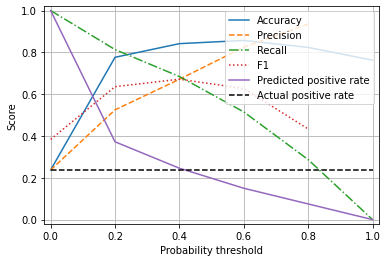

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

chart_x = results['thresholds']

plt.plot(chart_x, results['accuracy'],
         linestyle = '-',
         label = 'Accuracy')

plt.plot(chart_x, results['precision'],
         linestyle = '--',
         label = 'Precision')

plt.plot(chart_x, results['recall'],
         linestyle = '-.',
         label = 'Recall')

plt.plot(chart_x, results['f1'],
         linestyle = ':',
         label = 'F1')

plt.plot(chart_x, results['predicted_positive_rate'],
         linestyle = '-',
         label = 'Predicted positive rate')

actual_positive_rate = np.repeat(y.mean(), len(chart_x))

plt.plot(chart_x, actual_positive_rate,
         linestyle = '--',
         color='k',
         label = 'Actual positive rate')


plt.xlabel('Probability threshold')
plt.ylabel('Score')
plt.xlim(-0.02, 1.02)
plt.ylim(-0.02, 1.02)
plt.legend(loc='upper right')
plt.grid(True)

plt.show()

## Observations

* Accuracy is maximised with a probability threshold of 0.5
* When the threshold is set at 0.5 (the default threshold for classification) minority class ('survived') is under-predicted.
* A threshold of 0.4 balances precision and recall and correctly estimates the proportion of passengers who survive.
* There is a marginal reduction in overall accuracy in order to balance accuracy of the classes.